In [1]:
import sys
import torch 
sys.path.append("src")

In [3]:
from torch.utils.data import DataLoader
from dataloader import CollateFunctionSongDetection, SongDetectorDataClass


collate_fn = CollateFunctionSongDetection(segment_length=4096)

test_class = SongDetectorDataClass("/media/george-vengrovski/disk2/training_bengalese_finch_detector/test", augment=False)
test_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

train_class = SongDetectorDataClass("/media/george-vengrovski/disk2/training_bengalese_finch_detector/train", augment=False)
train_loader = DataLoader(train_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

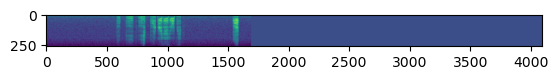

In [8]:
_, s = next(iter(test_loader))
import matplotlib.pyplot as plt

# reflect y axis
plt.imshow(_[0,0])

In [11]:
from model import TweetyNet
from trainer import Trainer 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

model = TweetyNet(hidden_size=32, rnn_dropout=0.2, num_classes=1, input_shape=(1, 256, 4096))
model = model.to(device)

Using device: cuda


Batch 10: FER = 16.89%, Train Loss = 0.3081, Val Loss = 0.4185
Batch 20: FER = 20.15%, Train Loss = 0.3680, Val Loss = 0.4145
Batch 30: FER = 20.53%, Train Loss = 0.2516, Val Loss = 0.3579
Batch 40: FER = 10.54%, Train Loss = 0.1724, Val Loss = 0.2670
Batch 50: FER = 8.82%, Train Loss = 0.2066, Val Loss = 0.2463
Batch 60: FER = 5.35%, Train Loss = 0.1826, Val Loss = 0.1979
Batch 70: FER = 5.38%, Train Loss = 0.1458, Val Loss = 0.2039
Batch 80: FER = 5.56%, Train Loss = 0.1046, Val Loss = 0.1990
Batch 90: FER = 5.08%, Train Loss = 0.0705, Val Loss = 0.1777
Batch 100: FER = 4.98%, Train Loss = 0.0781, Val Loss = 0.1834
Batch 110: FER = 4.41%, Train Loss = 0.0611, Val Loss = 0.1677
Batch 120: FER = 4.85%, Train Loss = 0.0809, Val Loss = 0.1833
Batch 130: FER = 3.54%, Train Loss = 0.0622, Val Loss = 0.1289
Batch 140: FER = 3.99%, Train Loss = 0.0650, Val Loss = 0.1391
Batch 150: FER = 4.05%, Train Loss = 0.0406, Val Loss = 0.1551
Batch 160: FER = 4.91%, Train Loss = 0.0452, Val Loss = 0.19

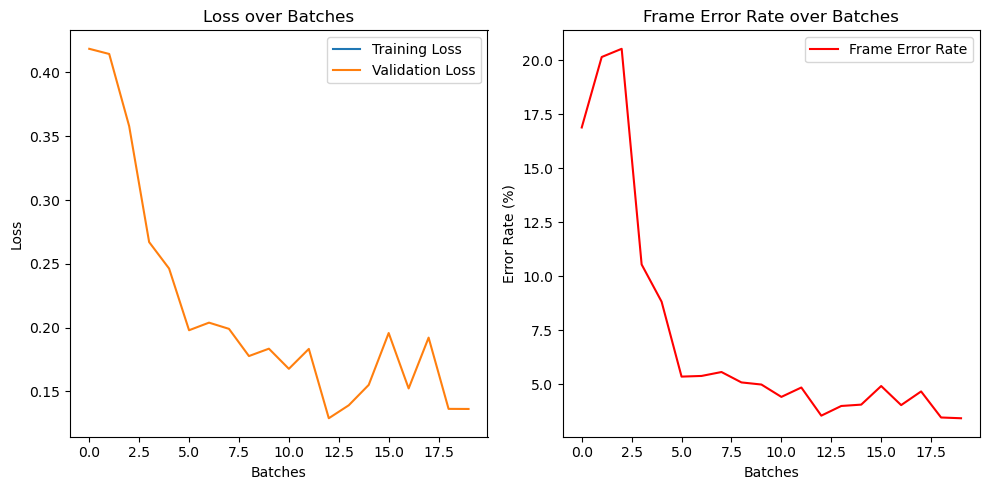

In [12]:
trainer = Trainer(model=model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=10, desired_total_batches=200, patience=8)
trainer.train()

In [13]:
from utils import save_model_config_and_weights

config = {
"model_name": "bengalese_finch_test",
"hidden_size": 32,
"context_size": 4096,
"batch_size": 24,
"num_batches_train": 100,
"lr": 3e-4
}

save_model_config_and_weights(trainer, config, config['model_name'])

Model config saved to /home/george-vengrovski/Documents/projects/tweety_net_song_detector/src/../files/bengalese_finch_test/config.json
Model weights saved to /home/george-vengrovski/Documents/projects/tweety_net_song_detector/src/../files/bengalese_finch_test/weights.pth


## Perusing 

First 10 logit values: [0.95515776 0.96953803 0.97502977 0.98014885 0.98268986 0.98402023
 0.9849215  0.98538184 0.98562604 0.98568255]


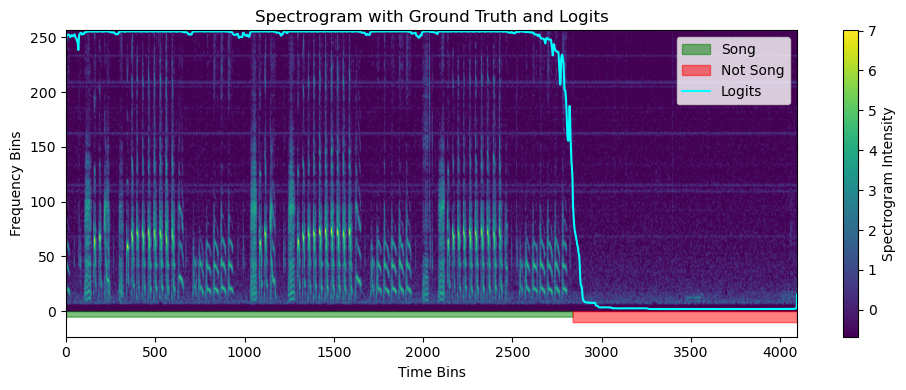

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_spectrogram_with_labels_and_logits(spec, ground_truth_label, logits):
    # Apply softmax to logits to scale them between 0 and 1
    logits_softmax = (logits.squeeze().detach().cpu()).numpy()  # Ensure logits is 1D before applying softmax

    # Print the first 10 logit values
    print("First 10 logit values:", logits_softmax[:10])

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot spectrogram
    plt.imshow(spec.numpy(), aspect='auto', origin='lower')

    # Overlay ground truth labels as bars at the bottom
    times = np.arange(ground_truth_label.shape[0])
    song_bar_height = np.full_like(ground_truth_label.numpy(), -5)  # Slightly below the spectrogram
    not_song_bar_height = np.full_like(ground_truth_label.numpy(), -10)  # Further below for clarity

    plt.fill_between(times, song_bar_height, where=ground_truth_label.numpy() > 0.5, color='green', step='mid', alpha=0.5, label='Song')
    plt.fill_between(times, not_song_bar_height, where=ground_truth_label.numpy() <= 0.5, color='red', step='mid', alpha=0.5, label='Not Song')

    # Overlay logits as a line plot
    plt.plot(times, logits_softmax * (spec.shape[0] - 1), color='cyan', label='Logits')  # Scale logits to match spectrogram's frequency range

    plt.colorbar(label='Spectrogram Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Spectrogram with Ground Truth and Logits')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `test_loader`, `model`, and `device` are defined and initialized in your code
spec, ground_truth_label = next(iter(test_loader))  # Get a batch from your DataLoader

logit = model(spec.to(device))  # Get model predictions

# Use the first example in the batch for plotting
spec = spec[0]
ground_truth_label = ground_truth_label[0]
logit = logit[0]  # Adjust based on your model's output shape

# Remove channel dimension if present
if spec.dim() > 2:
    spec = spec.squeeze(0)

# Plot using the function
plot_spectrogram_with_labels_and_logits(spec.cpu(), ground_truth_label.cpu(), logit.cpu())


## Validation

In [15]:
import numpy as np
import os
import matplotlib
# matplotlib.use('Agg')  # Use Agg backend for faster rendering
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

def process_spectrogram(spec, max_length=4096):
    """
    Process the spectrogram in chunks, pass through the classifier, and return the binary predictions based on BCE.
    """
    # Calculate the number of chunks needed
    num_chunks = int(np.ceil(spec.shape[1] / max_length))
    combined_predictions = []

    for i in range(num_chunks):
        # Extract the chunk
        start_idx = i * max_length
        end_idx = min((i + 1) * max_length, spec.shape[1])
        chunk = spec[:, start_idx:end_idx]
        # Forward pass through the model
        # Ensure chunk is on the correct device
        chunk_tensor = torch.Tensor(chunk).unsqueeze(0).unsqueeze(0).to(device)
        
        logits = model(chunk_tensor)
        logits = logits.squeeze().detach().cpu()

        combined_predictions.append(logits)

    # Concatenate all chunks' predictions
    final_predictions = np.concatenate(combined_predictions, axis=-1)

    return final_predictions

def compute_binary_sequence(song, threshold):
    """Convert a song signal into a binary sequence based on a threshold."""
    return (song >= threshold).astype(int)

def moving_average(signal, window_size):
    """Compute the moving average of the given signal with the specified window size."""
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def post_process_segments(smoothed_song, threshold, min_length, pad_song):
    """Post-process the smoothed song to adjust segments shorter than min_length and apply padding."""
    processed_song = np.zeros_like(smoothed_song)
    above_threshold = smoothed_song >= threshold
    start = None

    for i, value in enumerate(above_threshold):
        if value and start is None:
            start = i  # Mark the start of a new segment
        elif not value and start is not None:
            # Segment end found; check if it meets the min_length requirement
            if i - start >= min_length:
                # Apply padding to segments that meet the min_length requirement
                start_pad = max(start - pad_song, 0)  # Ensure start_pad is not less than 0
                end_pad = min(i + pad_song, len(above_threshold))  # Ensure end_pad does not exceed array length
                processed_song[start_pad:end_pad] = smoothed_song[start_pad:end_pad]
            start = None  # Reset start for the next segment

    # Handle the case where a segment extends to the end of the array
    if start is not None and len(above_threshold) - start >= min_length:
        start_pad = max(start - pad_song, 0)
        end_pad = min(len(above_threshold) + pad_song, len(above_threshold))
        processed_song[start_pad:end_pad] = smoothed_song[start_pad:end_pad]

    return processed_song

def compute_metrics(ground_truth, predictions):
    precision = precision_score(ground_truth, predictions, zero_division=0)
    recall = recall_score(ground_truth, predictions, zero_division=0)
    f1 = f1_score(ground_truth, predictions, zero_division=0)
    # Frame Error Rate (FER): ratio of incorrect frames to total frames
    total_frames = len(ground_truth)
    FP = np.sum((predictions == 1) & (ground_truth == 0))
    FN = np.sum((predictions == 0) & (ground_truth == 1))
    FER = (FP + FN) / total_frames
    return {'precision': precision, 'recall': recall, 'f1_score': f1, 'FER': FER}

def process_file(file_path, threshold, min_length, pad_song, group_output_dir, group_name):
    file_name = os.path.basename(file_path)
    metrics = None
    plotting_data = None
    try:
        f = np.load(file=file_path, allow_pickle=True)
        spec = f['s']
        song = f['song']

        mean_val, std_val = spec.mean(), spec.std()
        spec = (spec - mean_val) / (std_val + 1e-7)
        spec[np.isnan(spec)] = 0

        song[song == 2] = 0  # Set labels that are not 0 or 1 to 0

        # Process the spectrogram and get predictions
        predictions = process_spectrogram(spec)

        # Compute smoothed song
        smoothed_song = moving_average(predictions, window_size=100)

        # Post-process smoothed song
        processed_song = post_process_segments(smoothed_song, threshold, min_length, pad_song)

        processed_song = processed_song.astype(bool)
        song = song.astype(bool)
        metrics = compute_metrics(processed_song, song)

        # Collect plotting data
        plotting_data = {
            's': f['s'],
            'smoothed_song': smoothed_song,
            'processed_song': processed_song,
            'song_length': len(song),
            'file_name': file_name,
            'group_output_dir': group_output_dir,
            'song': song
        }

    except Exception as e:
        print(f"Failed to process file {file_name} in group {group_name}: {str(e)}")
    return metrics, plotting_data

def plot_with_classification_line(src_dirs, output_dir, threshold=0.5, min_length=500, pad_song=50):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    group_metrics = {}  # Dictionary to store metrics for each group

    for src in src_dirs:
        group_name = os.path.basename(src.rstrip('/'))
        group_output_dir = os.path.join(output_dir, group_name)
        if not os.path.exists(group_output_dir):
            os.makedirs(group_output_dir)

        files = [os.path.join(src, f) for f in os.listdir(src) if not f.endswith(('.bak', '.json', '.png'))]
        metrics_list = []  # List to store metrics for this group
        plotting_data_list = []

        # Process files sequentially
        for file_path in tqdm(files, desc=f"Processing group {group_name}"):
            metrics, plotting_data = process_file(file_path, threshold, min_length, pad_song, group_output_dir, group_name)
            if metrics:
                metrics_list.append(metrics)
            if plotting_data:
                plotting_data_list.append(plotting_data)

        # After processing all files, perform plotting sequentially
        for plotting_data in plotting_data_list:
            try:
                s = plotting_data['s']
                smoothed_song = plotting_data['smoothed_song']
                processed_song = plotting_data['processed_song']
                song_length = plotting_data['song_length']
                file_name = plotting_data['file_name']
                group_output_dir = plotting_data['group_output_dir']
                song = plotting_data['song']

                # Downsample the spectrogram along frequency axis only
                s_downsampled = s[::2, :]  # Downsample frequency axis

                fig, ax = plt.subplots(figsize=(10, 3))  # Smaller figure size for faster rendering
                ax.imshow(s_downsampled, aspect='auto', origin='lower')
                ax.set_ylabel('Frequency [Hz]')
                ax.set_xlabel('Time [sec]')

                # Plot smoothed song
                smoothed_times = np.arange(len(smoothed_song))  # Remove the +50 offset
                ax.plot(smoothed_times, smoothed_song * (s_downsampled.shape[0] - 1),
                color='magenta', label='Smoothed Classification Sigmoid', alpha=0.7)


                # Use fill_between to shade processed song regions without looping
                times = np.arange(len(processed_song)) + 50
                ax.fill_between(times, -5, 0, where=processed_song > 0,
                                color='red', alpha=0.5, step='pre')

                ax.set_ylim(bottom=-5, top=s_downsampled.shape[0] - 1)  # Adjust y-limits
                ax.set_xlim(left=0, right=s_downsampled.shape[1])  # Ensure x-limits match spectrogram
                ax.legend(loc='upper right')

                # Saving the plot with lower DPI
                output_file_path = os.path.join(group_output_dir,
                                                f"{os.path.splitext(file_name)[0]}_detection.png")
                plt.savefig(output_file_path, bbox_inches='tight', dpi=72)  # Lower DPI speeds up saving
                plt.close(fig)
            except Exception as e:
                print(f"Failed to plot file {file_name} in group {group_name}: {str(e)}")

        # Compute average metrics for this group
        if metrics_list:
            avg_precision = np.mean([m['precision'] for m in metrics_list])
            avg_recall = np.mean([m['recall'] for m in metrics_list])
            avg_f1 = np.mean([m['f1_score'] for m in metrics_list])
            avg_FER = np.mean([m['FER'] for m in metrics_list])

            group_metrics[group_name] = {
                'precision': avg_precision,
                'recall': avg_recall,
                'f1_score': avg_f1,
                'FER': avg_FER
            }

            print(f"Average metrics for group {group_name}: {group_metrics[group_name]}")
        else:
            print(f"No valid files were processed in group {group_name}.")

    # Plot (1 - FER) and F1 score for each group
    groups = list(group_metrics.keys())
    one_minus_FER = [1 - group_metrics[group]['FER'] for group in groups]
    f1_scores = [group_metrics[group]['f1_score'] for group in groups]

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, one_minus_FER, width, label='1 - FER')
    rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('1 - FER and F1 Score by Group')
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    # Attach a text label above each bar in rects
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

    # Return the group metrics
    return group_metrics

# Example usage
src_dirs = [
    "/media/george-vengrovski/disk2/training_song_detector/labeled_song_dataset/test"
]
output_dir = "/media/george-vengrovski/disk2/training_song_detector/validation_results"

group_metrics = plot_with_classification_line(src_dirs, output_dir, threshold=0.5, min_length=500, pad_song=50)

# Print the overall metrics
print("Group Metrics:")
for group_name, metrics in group_metrics.items():
    print(f"{group_name}: {metrics}")


plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/media/george-vengrovski/disk2/training_song_detector/labeled_song_dataset/test'

## Old Validation

In [ ]:
import os
import numpy as np
import torch
from tqdm import tqdm  # Import tqdm for progress tracking
import matplotlib.pyplot as plt  # Import matplotlib for plotting

def process_spectrogram(spec, max_length=4096):
    """
    Process the spectrogram in chunks, pass through the classifier, and return the binary predictions based on BCE.
    """
    # Calculate the number of chunks needed
    num_chunks = int(np.ceil(spec.shape[1] / max_length))
    combined_predictions = []

    for i in range(num_chunks):
        # Extract the chunk
        start_idx = i * max_length
        end_idx = min((i + 1) * max_length, spec.shape[1])
        chunk = spec[:, start_idx:end_idx]
        # Forward pass through the model
        # Ensure chunk is on the correct device
        chunk_tensor = torch.Tensor(chunk).unsqueeze(0).unsqueeze(0).to(device)
        
        logits = model(chunk_tensor)
        logits = logits.squeeze().detach().cpu()

        combined_predictions.append(logits)

    # Concatenate all chunks' predictions
    final_predictions = np.concatenate(combined_predictions, axis=-1)

    return final_predictions

def process_files(src):
    """
    Process each file in the directory, reshape predictions, and overwrite the original files with the processed data.
    """
    files = os.listdir(src)
    for file in tqdm(files, desc="Processing files"):  # Wrap the loop with tqdm for progress tracking
        file_path = os.path.join(src, file)

        if file.endswith('.bak'):
            continue

        try:
            # Load the spectrogram from the file
            f = np.load(file_path, allow_pickle=True)
            spec = f['s']
            song = f['song']

            # Z-score normalization
            spec_mean = spec.mean()
            spec_std = spec.std()
            spec = (spec - spec_mean) / spec_std

            # Process the spectrogram and get predictions
            predictions = process_spectrogram(spec)

            # Overwrite the original file with the spectrogram and predictions
            np.savez(file_path, s=spec, predictions=predictions, song=song)  

        except Exception as e:
            print(f"Failed to process file {file}: {str(e)}")

src = "/media/george-vengrovski/disk2/training_song_detector/fall_song_labeled"
process_files(src)

# Plotting the results in bar graphs
def plot_group_metrics(group_metrics):
    groups = list(group_metrics.keys())
    metrics = ['precision', 'recall', 'f1_score', 'FER']
    
    # Initialize the figure and axes
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
    
    for i, metric in enumerate(metrics):
        values = [group_metrics[group][metric] for group in groups]
        axes[i].bar(groups, values)
        axes[i].set_title(metric)
        axes[i].set_xlabel('Groups')
        axes[i].set_ylabel(metric)
    
    plt.tight_layout()
    plt.show()

# Example usage
src_dirs = [
    "/media/george-vengrovski/disk2/training_song_detector/test",
    "/media/george-vengrovski/disk2/training_song_detector/validation_test_set"
]
output_dir = "/media/george-vengrovski/disk2/training_song_detector/validation_results"

group_metrics = plot_with_classification_line(src_dirs, output_dir, threshold=0.5, min_length=500, pad_song=50)

# Print the overall metrics
print("Group Metrics:")
for group_name, metrics in group_metrics.items():
    print(f"{group_name}: {metrics}")

# Plot the group metrics
plot_group_metrics(group_metrics)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

def compute_binary_sequence(song, threshold):
    """Convert a song signal into a binary sequence based on a threshold."""
    return (song >= threshold).astype(int)

def compute_levenshtein_distance(ground_truth, predictions):
    """Compute Levenshtein distance between ground truth and prediction sequences."""
    return Levenshtein.distance(ground_truth.tostring(), predictions.tostring())

def moving_average(signal, window_size):
    """Compute the moving average of the given signal with the specified window size."""
    cumsum_vec = np.cumsum(np.insert(signal, 0, 0)) 
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

def post_process_segments(smoothed_song, threshold, min_length, pad_song):
    """Post-process the smoothed song to adjust segments shorter than min_length and apply padding."""
    processed_song = np.zeros_like(smoothed_song)
    above_threshold = smoothed_song >= threshold
    start = None

    for i, value in enumerate(above_threshold):
        if value and start is None:
            start = i  # Mark the start of a new segment
        elif not value and start is not None:
            # Segment end found; check if it meets the min_length requirement
            if i - start >= min_length:
                # Apply padding to segments that meet the min_length requirement
                start_pad = max(start - pad_song, 0)  # Ensure start_pad is not less than 0
                end_pad = min(i + pad_song, len(above_threshold))  # Ensure end_pad does not exceed array length
                processed_song[start_pad:end_pad] = smoothed_song[start_pad:end_pad]
            start = None  # Reset start for the next segment

    # Handle the case where a segment extends to the end of the array
    if start is not None and len(above_threshold) - start >= min_length:
        start_pad = max(start - pad_song, 0)
        end_pad = min(len(above_threshold) + pad_song, len(above_threshold))
        processed_song[start_pad:end_pad] = smoothed_song[start_pad:end_pad]

    return processed_song

def plot_with_classification_line(src, output_dir, threshold=0.5, min_length=500, pad_song=50):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(src)
    levenshtein_distances = []  # Store Levenshtein distances

    for file_name in files:
        file_path = os.path.join(src, file_name)

        if file_name.endswith('.bak') or file_name.endswith('.json') or file_name.endswith('.png'):
            continue

        f = np.load(file=file_path, allow_pickle=True)

        predictions = f['predictions']
        song = f['song']

        # Plotting
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.imshow(f['s'], aspect='auto', origin='lower')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')

        # Compute and plot smoothed line
        smoothed_song = moving_average(predictions, window_size=100)
        smoothed_times = np.arange(len(smoothed_song)) + 50  # Offset for alignment
        ax.plot(smoothed_times, smoothed_song * (f['s'].shape[0] - 1), color='magenta', label='Smoothed Classification Sigmoid', alpha=0.7)

        # Post-process smoothed song to adjust short segments and apply padding
        processed_song = post_process_segments(smoothed_song, threshold, min_length, pad_song)

        # Add a color bar below the spectrogram based on the processed song data
        for i in range(len(processed_song)):
            color = 'red' if processed_song[i] > 0 else 'blue'
            ax.axhspan(ymin=-5, ymax=0, xmin=(i + 50) / len(song), xmax=(i + 51) / len(song), color=color)

        ax.set_ylim(bottom=-5)  # Adjust y-axis to include the new bar

        # Adjust legend to include both lines
        ax.legend(loc='upper right')

        # Saving the plot
        output_file_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_detection.png")
        plt.savefig(output_file_path, bbox_inches='tight')
        plt.close(fig)

        # Compute Levenshtein distance between post-processed predictions and ground truth
        ground_truth_binary = compute_binary_sequence(song, threshold)
        processed_song_binary = compute_binary_sequence(processed_song, threshold)

        levenshtein_distance = compute_levenshtein_distance(ground_truth_binary, processed_song_binary)

        # Store Levenshtein distance
        levenshtein_distances.append(levenshtein_distance)

        print(f"Levenshtein distance for {file_name}: {levenshtein_distance}")

    # Compute and print average Levenshtein distance
    if levenshtein_distances:
        avg_levenshtein_distance = np.mean(levenshtein_distances)
        print(f"Average Levenshtein distance: {avg_levenshtein_distance}")
    else:
        print("No valid files were processed.")

# Example usage
src = "/media/george-vengrovski/disk2/training_song_detector/validation_test_set"
output_dir = "/media/george-vengrovski/disk2/training_song_detector/validation_test_set"
plot_with_classification_line(src, output_dir, threshold=0.5, min_length=500, pad_song=50) ~~~ This is my validation notebook .... change levenstein distance to f1 metric and just basic FER ... also instead of reading and writing back to file ... when reading the file, process it, compute metrics and save metrics to memory. Allow for multiple src directories which  are processed and compared as seperate groups!